In [1]:
# Install necessary libraries
!pip install -q pandas gdown

# Import libraries
import pandas as pd
import gdown

# --- 1. Download Historical Trader Data ---
trader_url = 'https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs'
trader_file = 'trader_data.csv'
gdown.download(trader_url, trader_file, quiet=False)

# Load into pandas DataFrame
trader_df = pd.read_csv(trader_file)
print("📊 Trader Data Preview:")
print(trader_df.head())

# --- 2. Download Fear-Greed Index Data ---
fg_url = 'https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf'
fg_file = 'fear_greed.csv'
gdown.download(fg_url, fg_file, quiet=False)

# Load into pandas DataFrame
fg_df = pd.read_csv(fg_file)
print("\n📈 Fear-Greed Index Preview:")
print(fg_df.head())


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/trader_data.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 96.0MB/s]


📊 Trader Data Preview:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \


Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/fear_greed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 65.8MB/s]


📈 Fear-Greed Index Preview:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05


In [2]:
# Step 1: Convert 'Timestamp IST' to datetime and extract date
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
trader_df['date'] = trader_df['Timestamp IST'].dt.date  # Add new date column

# Step 2: Convert fear/greed 'date' column to datetime.date
fg_df['date'] = pd.to_datetime(fg_df['date']).dt.date

# Step 3: Merge on 'date'
merged_df = pd.merge(trader_df, fg_df[['date', 'classification']], on='date', how='left')

# Step 4: Preview merged data
print("📎 Merged Data Sample:")
print(merged_df[['Account', 'Execution Price', 'Side', 'Closed PnL', 'date', 'classification']].head())


📎 Merged Data Sample:
                                      Account  Execution Price Side  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9769  BUY   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9800  BUY   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9855  BUY   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9874  BUY   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9894  BUY   

   Closed PnL        date classification  
0         0.0  2024-12-02  Extreme Greed  
1         0.0  2024-12-02  Extreme Greed  
2         0.0  2024-12-02  Extreme Greed  
3         0.0  2024-12-02  Extreme Greed  
4         0.0  2024-12-02  Extreme Greed  


In [3]:
# Group by sentiment and calculate average Closed PnL and number of trades
summary = merged_df.groupby('classification').agg(
    avg_pnl=('Closed PnL', 'mean'),
    total_trades=('Closed PnL', 'count'),
    total_positive_trades=('Closed PnL', lambda x: (x > 0).sum()),
    total_negative_trades=('Closed PnL', lambda x: (x < 0).sum())
).reset_index()

# Add success rate
summary['success_rate'] = (summary['total_positive_trades'] / summary['total_trades']) * 100

print("📊 Performance Summary by Sentiment:")
print(summary)


📊 Performance Summary by Sentiment:
  classification    avg_pnl  total_trades  total_positive_trades  \
0   Extreme Fear  34.537862         21400                   7931   
1  Extreme Greed  67.892861         39992                  18594   
2           Fear  54.290400         61837                  26019   
3          Greed  42.743559         50303                  19358   
4        Neutral  34.307718         37686                  14961   

   total_negative_trades  success_rate  
0                   2475     37.060748  
1                   2259     46.494299  
2                   3789     42.076750  
3                   5818     38.482794  
4                   3198     39.699093  


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(x='classification', y='avg_pnl', data=summary, palette='coolwarm')
plt.title('Average Closed PnL by Market Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Average Closed PnL')
plt.grid(True)
plt.show()


NameError: name 'summary' is not defined

<Figure size 800x500 with 0 Axes>

In [2]:
# Group by sentiment and calculate average Closed PnL and number of trades
summary = merged_df.groupby('classification').agg(
    avg_pnl=('Closed PnL', 'mean'),
    total_trades=('Closed PnL', 'count'),
    total_positive_trades=('Closed PnL', lambda x: (x > 0).sum()),
    total_negative_trades=('Closed PnL', lambda x: (x < 0).sum())
).reset_index()

# Add success rate
summary['success_rate'] = (summary['total_positive_trades'] / summary['total_trades']) * 100

print("📊 Performance Summary by Sentiment:")
print(summary)


NameError: name 'merged_df' is not defined

Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/trader_data.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 161MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/fear_greed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 3.65MB/s]


📊 Performance Summary by Market Sentiment:
  classification    avg_pnl  total_trades  total_positive_trades  \
0   Extreme Fear  34.537862         21400                   7931   
1  Extreme Greed  67.892861         39992                  18594   
2           Fear  54.290400         61837                  26019   
3          Greed  42.743559         50303                  19358   
4        Neutral  34.307718         37686                  14961   

   total_negative_trades  success_rate  
0                   2475     37.060748  
1                   2259     46.494299  
2                   3789     42.076750  
3                   5818     38.482794  
4                   3198     39.699093  


/tmp/ipython-input-3-1739778399.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='avg_pnl', data=summary, palette='coolwarm')


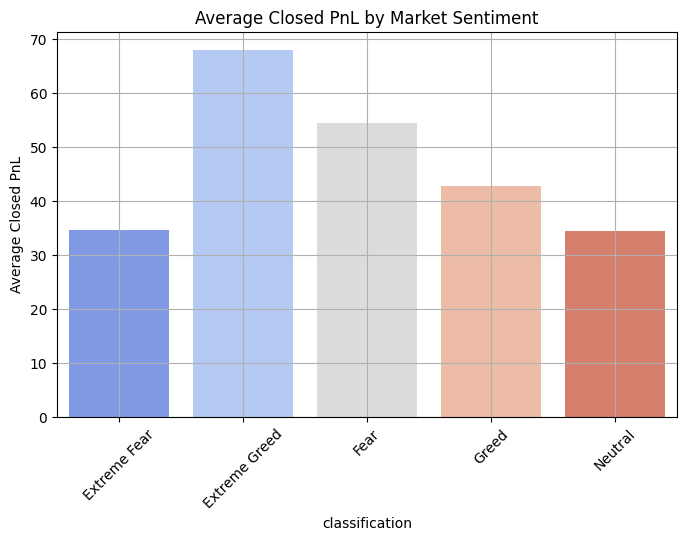

/tmp/ipython-input-3-1739778399.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='total_trades', data=summary, palette='viridis')


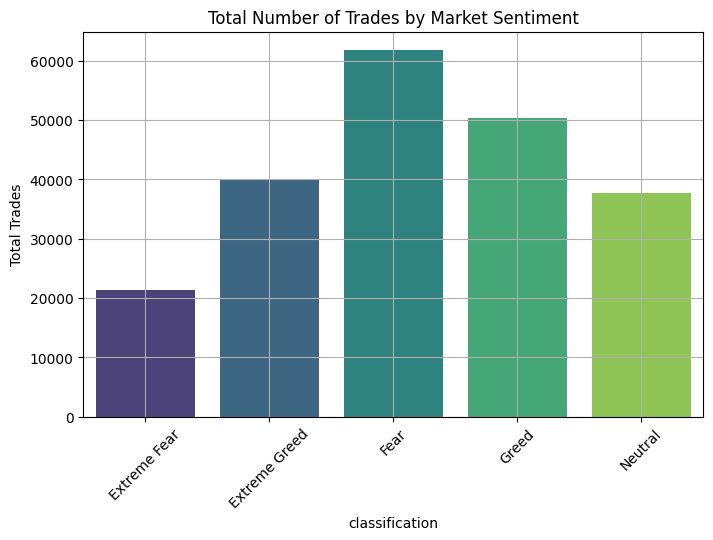

/tmp/ipython-input-3-1739778399.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='success_rate', data=summary, palette='Set2')


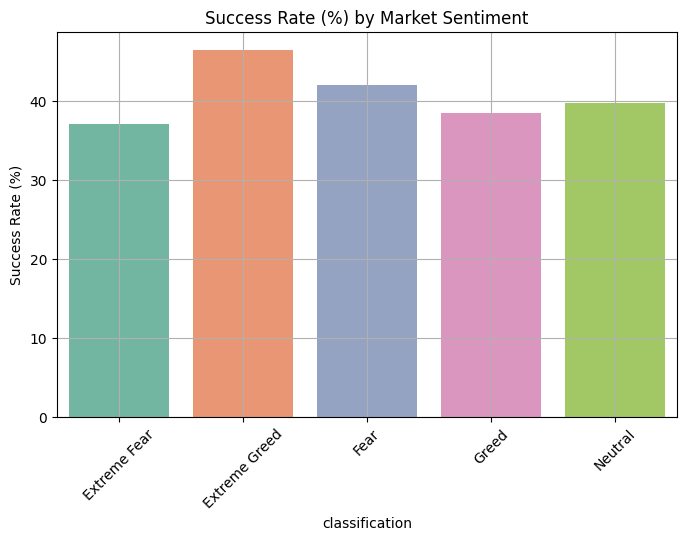

In [3]:
# Install required packages
!pip install -q pandas gdown seaborn matplotlib

# Import libraries
import pandas as pd
import gdown
import seaborn as sns
import matplotlib.pyplot as plt

# --- Download Trader Data ---
trader_url = 'https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs'
trader_file = 'trader_data.csv'
gdown.download(trader_url, trader_file, quiet=False)

# --- Download Fear-Greed Index Data ---
fg_url = 'https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf'
fg_file = 'fear_greed.csv'
gdown.download(fg_url, fg_file, quiet=False)

# --- Load Data ---
trader_df = pd.read_csv(trader_file)
fg_df = pd.read_csv(fg_file)

# --- Preprocessing & Merge ---
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
trader_df['date'] = trader_df['Timestamp IST'].dt.date
fg_df['date'] = pd.to_datetime(fg_df['date']).dt.date
merged_df = pd.merge(trader_df, fg_df[['date', 'classification']], on='date', how='left')

# --- Summary Stats ---
summary = merged_df.groupby('classification').agg(
    avg_pnl=('Closed PnL', 'mean'),
    total_trades=('Closed PnL', 'count'),
    total_positive_trades=('Closed PnL', lambda x: (x > 0).sum()),
    total_negative_trades=('Closed PnL', lambda x: (x < 0).sum())
).reset_index()
summary['success_rate'] = (summary['total_positive_trades'] / summary['total_trades']) * 100

# --- Print Summary ---
print("📊 Performance Summary by Market Sentiment:")
print(summary)

# --- Plot Avg PnL ---
plt.figure(figsize=(8, 5))
sns.barplot(x='classification', y='avg_pnl', data=summary, palette='coolwarm')
plt.title('Average Closed PnL by Market Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Average Closed PnL')
plt.grid(True)
plt.show()

# --- Plot Number of Trades ---
plt.figure(figsize=(8, 5))
sns.barplot(x='classification', y='total_trades', data=summary, palette='viridis')
plt.title('Total Number of Trades by Market Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Total Trades')
plt.grid(True)
plt.show()

# --- Plot Success Rate ---
plt.figure(figsize=(8, 5))
sns.barplot(x='classification', y='success_rate', data=summary, palette='Set2')
plt.title('Success Rate (%) by Market Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Success Rate (%)')
plt.grid(True)
plt.show()
